In [4]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import math
import tiktoken
import torch
import torch.nn as nn

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


In [5]:
# Hyperparameters
batch_size = 4  # How many batches per training step
context_length = 16  # Length of the token chunk each batch
d_model = 64  # The vector size of the token embeddings
num_layers = 8  # Number of transformer blocks
num_heads = 4  # Number of heads in Multi-head attention # 我们的代码中通过 d_model / num_heads = 来获取 head_size
learning_rate = 1e-3  # 0.001
dropout = 0.1 # Dropout rate
max_iters = 500  # Total of training iterations
eval_interval = 50  # How often to evaluate the model 
eval_iters = 20  # How many iterations to average the loss over when evaluating the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Instead of using the cpu, we'll use the GPU if it's available.

TORCH_SEED = 1337
torch.manual_seed(TORCH_SEED)

In [6]:
# download a sample txt file from https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/raw/main/sales_textbook.txt
if not os.path.exists('data/sales_textbook.txt'):
    url = 'https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/raw/main/sales_textbook.txt'
    with open('sales_textbook.txt', 'w') as f:
        f.write(requests.get(url).text)

with open('data/sales_textbook.txt', 'r', encoding='utf-8') as f:
    text = f.read()
print(text[1])

h


In [7]:
def compare_encodings(example_string: str) -> None:
    """Prints a comparison of three string encodings."""
    # print the example string
    print(f'\nExample string: "{example_string}"')
    # for each encoding, print the # of tokens, the token integers, and the token bytes
    for encoding_name in ["gpt2", "p50k_base", "cl100k_base"]:
        encoding = tiktoken.get_encoding(encoding_name)
        token_integers = encoding.encode(example_string)
        num_tokens = len(token_integers)
        token_bytes = [encoding.decode_single_token_bytes(token) for token in token_integers]
        print()
        print(f"{encoding_name}: {num_tokens} tokens")
        print(f"token integers: {token_integers}")
        print(f"token bytes: {token_bytes}")

compare_encodings("hello, I'm your old brother! you don't know who I am")
compare_encodings("2 + 2 = 4")
compare_encodings("お誕生日おめでとう")


Example string: "hello, I'm your old brother! you don't know who I am"

gpt2: 15 tokens
token integers: [31373, 11, 314, 1101, 534, 1468, 3956, 0, 345, 836, 470, 760, 508, 314, 716]
token bytes: [b'hello', b',', b' I', b"'m", b' your', b' old', b' brother', b'!', b' you', b' don', b"'t", b' know', b' who', b' I', b' am']

p50k_base: 15 tokens
token integers: [31373, 11, 314, 1101, 534, 1468, 3956, 0, 345, 836, 470, 760, 508, 314, 716]
token bytes: [b'hello', b',', b' I', b"'m", b' your', b' old', b' brother', b'!', b' you', b' don', b"'t", b' know', b' who', b' I', b' am']

cl100k_base: 15 tokens
token integers: [15339, 11, 358, 2846, 701, 2362, 10868, 0, 499, 1541, 956, 1440, 889, 358, 1097]
token bytes: [b'hello', b',', b' I', b"'m", b' your', b' old', b' brother', b'!', b' you', b' don', b"'t", b' know', b' who', b' I', b' am']

Example string: "2 + 2 = 4"

gpt2: 5 tokens
token integers: [17, 1343, 362, 796, 604]
token bytes: [b'2', b' +', b' 2', b' =', b' 4']

p50k_base: 5 tokens


In [8]:
# Using TikToken to tokenize the source text
encoding = tiktoken.get_encoding("cl100k_base")
tokenized_text = encoding.encode(text)
tokenized_text = torch.tensor(tokenized_text, dtype=torch.long, device=device) # Convert tokens into a tensor
max_token_value = tokenized_text.max().item() # the maximum index value in our vocabulary

print(f"Tokenized text size: {len(tokenized_text)}")
print(f"The maximum value in the tokenized text is: {max_token_value}")

Tokenized text size: 77919
The maximum value in the tokenized text is: 100069


In [9]:
print(tokenized_text.max())

tensor(100069, device='cuda:0')


## OpenAI官方分词工具
https://platform.openai.com/tokenizer  

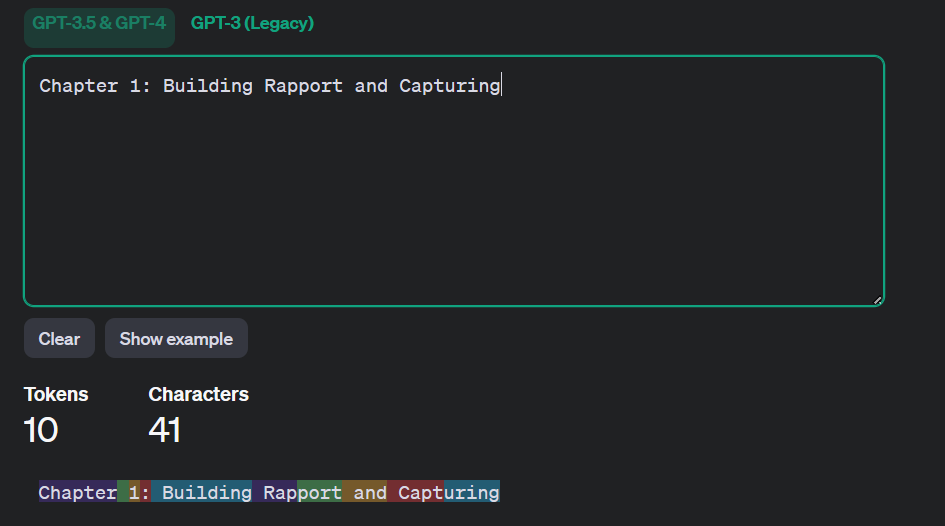

In [10]:
# Illustration purpose
text = 'Chapter 1: Building Rapport and Capturing'
encoding_integar = encoding.encode(text)
print(encoding_integar)
# for i in encoding_integar:
#     token_bytes = encoding.decode_single_token_bytes(i)
#     print(token_bytes)
print(encoding.decode(encoding_integar))

[26072, 220, 16, 25, 17283, 23097, 403, 323, 17013, 1711]
Chapter 1: Building Rapport and Capturing


In [11]:
# Split train and validation
split_idx = int(len(tokenized_text) * 0.9)
train_data = tokenized_text[:split_idx]
val_data = tokenized_text[split_idx:]

In [12]:
# Prepare data for training batch
data = train_data
idxs = torch.randint(low=0, high=len(data) - context_length, size=(batch_size,))
print(idxs)
x_batch = torch.stack([data[idx:idx + context_length] for idx in idxs])
y_batch = torch.stack([data[idx + 1:idx + context_length + 1] for idx in idxs])
print(x_batch.shape, x_batch.shape)
print(x_batch.data)

tensor([35754, 55550, 63572,  1447])
torch.Size([4, 16]) torch.Size([4, 16])
tensor([[  279,  6763,  1920,    13,   578,  5845,   311, 13750, 19570,   279,
           907,   323,  7720,   315,  1057,  3956],
        [ 3495, 14955,    11,   477,  5064, 23146,   430,  9788,   279, 66732,
           315,   701, 10209,    13,  3296, 32644],
        [38769, 10742,    11, 20958,   264,  6928, 19451,    11, 11125, 64784,
            11,   323, 56501, 54111,   439,  6975],
        [43496,   872,  8830,   719,  1101,  3727,   279,  6130,  2733,  6755,
           323, 16365,   627, 29831, 19682,  5900]], device='cuda:0')


In [13]:
data[61650]

tensor(907, device='cuda:0')

In [14]:
# Illustration purpose
pd.set_option('display.expand_frame_repr', False)
print("Our batches:\n", pd.DataFrame(x_batch.detach().cpu().numpy()))

Our batches:
       0      1     2      3     4      5      6      7      8      9    10     11     12     13     14     15
0    279   6763  1920     13   578   5845    311  13750  19570    279  907    323   7720    315   1057   3956
1   3495  14955    11    477  5064  23146    430   9788    279  66732  315    701  10209     13   3296  32644
2  38769  10742    11  20958   264   6928  19451     11  11125  64784   11    323  56501  54111    439   6975
3  43496    872  8830    719  1101   3727    279   6130   2733   6755  323  16365    627  29831  19682   5900


In [15]:
# Define Token Embedding look-up table
token_embedding_lookup_table = nn.Embedding(max_token_value+1, d_model).to(device) #gpt3 使用的是50257 * 2400 = 120616800 = 1.2亿
print("Token Embedding Look-up table: ", token_embedding_lookup_table)

Token Embedding Look-up table:  Embedding(100070, 64)


In [16]:
_ = token_embedding_lookup_table(data[61650]) # 
pd.set_option('expand_frame_repr', True)
pd.DataFrame(_.detach().cpu().numpy())

,0
0,0.370826
1,0.272521
2,-1.915345
3,0.032303
4,0.017929
...,...
59,1.097342
60,0.231425
61,0.104482
62,-1.583871


In [17]:
# Get x and y embedding
x_batch_embedding = token_embedding_lookup_table(x_batch.detach().to(device)) # [4, 16, 64] [batch_size, context_length, d_model]
y_batch_embedding = token_embedding_lookup_table(y_batch.detach().to(device))

x_batch_embedding.shape, y_batch_embedding.shape
pd.DataFrame(x_batch_embedding[0].detach().cpu().numpy())


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,1.399742,-1.206918,0.327990,-0.251130,0.531874,-0.248193,0.351938,-0.389238,0.129977,-1.207580,...,-0.547752,1.515671,1.223743,0.833670,-0.404194,0.563555,0.591292,-0.724745,1.670105,-0.241721
1,0.566486,-1.102276,1.712332,-0.354509,0.550577,-0.707943,-0.743899,0.757765,0.018193,1.392380,...,0.873562,1.226714,0.794431,0.598629,0.884421,0.032520,1.353617,0.059697,1.172510,0.527427
2,-0.426478,1.717362,-0.343810,-0.917124,-0.273610,0.695366,-0.849842,-1.301135,-0.162554,-0.252810,...,-0.934960,1.145729,-1.914150,-0.447346,0.597272,1.673483,-1.969475,0.397835,-0.438475,-0.562923
3,0.709939,1.369311,-0.707588,1.538689,-2.110915,0.441344,-0.005807,0.171597,-0.296632,0.207320,...,0.071533,-0.735549,0.069967,-2.744750,1.087368,-0.997812,0.714992,-1.357311,1.603957,0.920290
4,-1.963246,0.298927,0.131364,0.082995,0.153765,-0.821641,-1.220109,-1.088038,1.535371,1.829628,...,0.531913,-0.567854,-2.390947,-0.086596,0.066017,0.655226,0.624369,-0.763375,-0.692774,-0.007724
5,0.811149,0.435134,1.131030,0.816734,-1.013971,-0.052429,-0.527541,-0.710573,-0.163887,-1.343154,...,-0.046995,-1.201052,-0.927833,0.322523,0.586139,0.108184,-1.653296,1.918813,0.941642,0.584330
6,0.317549,2.106441,-0.092210,0.636316,-0.912476,-1.975633,-0.068806,0.201157,0.333519,0.151939,...,0.200116,0.051824,1.304806,0.517675,0.049345,0.044632,1.346794,-0.321390,-0.478787,-0.166920
7,-2.025703,1.256391,-0.318619,1.432163,1.644837,-1.910154,-1.001209,-0.976038,1.502204,0.841974,...,-2.339570,0.190785,-0.055200,2.281739,-0.417175,-0.801704,-1.393716,1.863095,-0.393567,-0.131746
8,2.906978,0.092020,-0.785242,0.609121,-0.790180,-0.026004,-1.156866,0.398455,-0.455395,-0.251288,...,3.363073,-0.796739,1.757077,1.526690,-0.654219,1.660685,0.965431,0.618787,1.662946,1.768386
9,1.399742,-1.206918,0.327990,-0.251130,0.531874,-0.248193,0.351938,-0.389238,0.129977,-1.207580,...,-0.547752,1.515671,1.223743,0.833670,-0.404194,0.563555,0.591292,-0.724745,1.670105,-0.241721


### 位置编码 Position Encoding PE

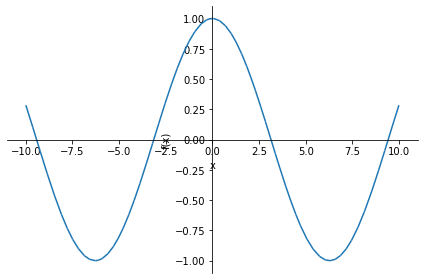

In [18]:
import sympy
x = sympy.symbols('x')
sinx = sympy.cos(0.5*x)
sympy.plot(sinx)

In [19]:
# Define Position Encoding look-up table
position_encoding_lookup_table = torch.zeros(context_length, d_model)
position = torch.arange(0, context_length, dtype=torch.float).unsqueeze(1)
div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
#div_term_ = 1/(10000 ** (torch.arange(0, d_model, 2).float()/d_model))
position_encoding_lookup_table[:, 0::2] = torch.sin(position * div_term)
position_encoding_lookup_table[:, 1::2] = torch.cos(position * div_term)
position_encoding_lookup_table = position_encoding_lookup_table.unsqueeze(0).expand(batch_size, -1, -1) #add batch dimension

print("Position Encoding Look-up Table: ", position_encoding_lookup_table.shape) # [4, 16, 64] [batch_size, context_length, d_model]
pd.DataFrame(position_encoding_lookup_table[0].detach().cpu().numpy())


Position Encoding Look-up Table:  torch.Size([4, 16, 64])


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,0.841471,0.540302,0.681561,0.731761,0.533168,0.846009,0.409309,0.912396,0.310984,0.950415,...,0.000422,1.000000,0.000316,1.000000,0.000237,1.000000,0.000178,1.000000,0.000133,1.000000
2,0.909297,-0.416147,0.997480,0.070948,0.902131,0.431463,0.746903,0.664932,0.591127,0.806578,...,0.000843,1.000000,0.000632,1.000000,0.000474,1.000000,0.000356,1.000000,0.000267,1.000000
3,0.141120,-0.989992,0.778273,-0.627927,0.993253,-0.115966,0.953634,0.300967,0.812649,0.582754,...,0.001265,0.999999,0.000949,1.000000,0.000711,1.000000,0.000533,1.000000,0.000400,1.000000
4,-0.756802,-0.653644,0.141539,-0.989933,0.778472,-0.627680,0.993281,-0.115730,0.953581,0.301137,...,0.001687,0.999999,0.001265,0.999999,0.000949,1.000000,0.000711,1.000000,0.000533,1.000000
5,-0.958924,0.283662,-0.571127,-0.820862,0.323935,-0.946079,0.858896,-0.512150,0.999947,-0.010342,...,0.002108,0.999998,0.001581,0.999999,0.001186,0.999999,0.000889,1.000000,0.000667,1.000000
6,-0.279415,0.960170,-0.977396,-0.211416,-0.230368,-0.973104,0.574026,-0.818837,0.947148,-0.320796,...,0.002530,0.999997,0.001897,0.999998,0.001423,0.999999,0.001067,0.999999,0.000800,1.000000
7,0.656987,0.753902,-0.859313,0.511449,-0.713721,-0.700430,0.188581,-0.982058,0.800422,-0.599437,...,0.002952,0.999996,0.002214,0.999998,0.001660,0.999999,0.001245,0.999999,0.000933,1.000000
8,0.989358,-0.145500,-0.280228,0.959933,-0.977262,-0.212036,-0.229904,-0.973213,0.574318,-0.818632,...,0.003374,0.999994,0.002530,0.999997,0.001897,0.999998,0.001423,0.999999,0.001067,0.999999
9,0.412118,-0.911130,0.449194,0.893434,-0.939824,0.341660,-0.608108,-0.793854,0.291259,-0.956644,...,0.003795,0.999993,0.002846,0.999996,0.002134,0.999998,0.001600,0.999999,0.001200,0.999999


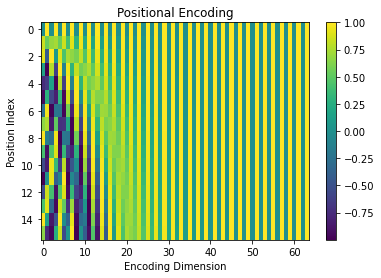

In [20]:
# Illustration Purpose Only
def visualize_pe(pe):
    plt.imshow(pe, aspect="auto")
    plt.title("Positional Encoding")
    plt.xlabel("Encoding Dimension")
    plt.ylabel("Position Index")
    plt.colorbar()
    plt.show()

position_encoding_lookup_table2_np = position_encoding_lookup_table[0].cpu().numpy()
visualize_pe(position_encoding_lookup_table2_np)

In [21]:
# Add positional encoding into the input embedding vector
input_embedding_x = x_batch_embedding + position_encoding_lookup_table.to(device) # [4, 16, 64] [batch_size, context_length, d_model]
input_embedding_y = y_batch_embedding + position_encoding_lookup_table.to(device)
pd.DataFrame(input_embedding_x[0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,1.399742,-0.206918,0.327990,0.748870,0.531874,0.751807,0.351938,0.610762,0.129977,-0.207580,...,-0.547752,2.515671,1.223743,1.833670,-0.404194,1.563555,0.591292,0.275255,1.670105,0.758279
1,1.407957,-0.561974,2.393893,0.377252,1.083746,0.138066,-0.334590,1.670161,0.329176,2.342795,...,0.873984,2.226714,0.794747,1.598629,0.884658,1.032520,1.353795,1.059697,1.172643,1.527427
2,0.482819,1.301215,0.653670,-0.846175,0.628521,1.126829,-0.102938,-0.636202,0.428573,0.553769,...,-0.934116,2.145729,-1.913517,0.552654,0.597746,2.673483,-1.969119,1.397835,-0.438208,0.437077
3,0.851059,0.379319,0.070685,0.910763,-1.117662,0.325378,0.947827,0.472564,0.516017,0.790074,...,0.072798,0.264451,0.070916,-1.744750,1.088080,0.002188,0.715526,-0.357311,1.604357,1.920290
4,-2.720048,-0.354717,0.272903,-0.906938,0.932237,-1.449321,-0.226828,-1.203768,2.488952,2.130765,...,0.533600,0.432145,-2.389682,0.913403,0.066965,1.655225,0.625080,0.236625,-0.692241,0.992275
5,-0.147775,0.718796,0.559903,-0.004127,-0.690035,-0.998508,0.331355,-1.222723,0.836060,-1.353497,...,-0.044886,-0.201054,-0.926252,1.322522,0.587324,1.108183,-1.652407,2.918813,0.942309,1.584330
6,0.038134,3.066611,-1.069607,0.424900,-1.142844,-2.948736,0.505219,-0.617680,1.280667,-0.168857,...,0.202646,1.051821,1.306703,1.517673,0.050767,1.044631,1.347860,0.678610,-0.477987,0.833080
7,-1.368717,2.010294,-1.177933,1.943613,0.931115,-2.610583,-0.812628,-1.958096,2.302625,0.242536,...,-2.336618,1.190780,-0.052987,3.281737,-0.415515,0.198294,-1.392472,2.863094,-0.392633,0.868254
8,3.896336,-0.053480,-1.065470,1.569054,-1.767442,-0.238040,-1.386770,-0.574759,0.118923,-1.069920,...,3.366446,0.203255,1.759607,2.526687,-0.652322,2.660683,0.966853,1.618786,1.664013,2.768385
9,1.811860,-2.118048,0.777184,0.642304,-0.407949,0.093468,-0.256171,-1.183092,0.421236,-2.164224,...,-0.543957,2.515664,1.226589,1.833666,-0.402059,1.563552,0.592893,0.275254,1.671305,0.758279


In [22]:
# Prepare Query, Key, Value for Multi-head Attention
X = input_embedding_x
query = key = value = X # [4, 16, 64] [batch_size, context_length, d_model]
query.shape

torch.Size([4, 16, 64])

In [23]:
# Define Query, Key, Value weight matrices #12228*12228*3 96个head 96层
Wq = nn.Linear(d_model, d_model).to(device)
Wk = nn.Linear(d_model, d_model).to(device)
Wv = nn.Linear(d_model, d_model).to(device)

Q = Wq(query).to(device) #[4, 16, 64]
Q = Q.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

K = Wk(key).to(device) #[4, 16, 64]
K = K.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

V = Wv(value).to(device)#[4, 16, 64]
V = V.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

# print(torch.round(Q[0] * 100) / 100)
qqq = Q.detach().cpu().numpy()
pd.set_option('expand_frame_repr', False)
for qs in qqq:
    for qss in qs:
        print(pd.DataFrame(qss))

print(Q.shape) # [4, 16, 4, 16] [batch_size, context_length, num_heads, head_size]

         0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15
0  0.843055 -0.550052 -0.127732 -0.844841 -0.819224  0.063522 -0.187879  1.182711 -1.542636  0.582238  0.123996 -0.023149  0.141312  0.812356 -1.628145  0.312126
1 -0.350486  0.484634 -0.140094  0.746821  1.481563 -0.266804  0.312059 -0.710153 -0.557109  0.462987 -0.575465  0.824084 -0.910005 -0.060633 -0.851141 -0.696344
2 -0.140998 -0.055692 -0.718412 -0.797249  0.366570  1.513673  0.577341 -0.707246 -0.275017  1.270265 -0.846118 -1.158900  1.652280  0.261800 -0.884520 -0.846511
3 -0.244500  0.759894  0.067822  0.388658 -0.178537  1.044808 -0.276759 -0.887758 -0.158977 -0.619547 -0.298364 -0.604880 -1.250720  0.388842 -1.088378  0.081781
         0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15
0  0.614938 -0.657467  0.080

In [24]:
# Transpose q,k,v from [batch_size, context_length, num_heads, head_size] to [batch_size, num_heads, context_length, head_size]
# The reason is that treat each batch with "num_heads" as its first dimension.
Q = Q.transpose(1, 2) # [4, 4, 16, 16]
K = K.transpose(1, 2) # [4, 4, 16, 16]
V = V.transpose(1, 2) # [4, 4, 16, 16]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.827912,0.872087,0.805252,0.638937,0.403635,-0.220579,0.074281,0.066308,0.161097,0.776865,-0.015753,0.059171,-0.167397,-0.519080,-0.113654,0.370162
1,1.123528,0.464093,0.514921,-0.184883,0.292600,-0.127225,0.205937,0.207778,0.602376,1.016719,0.158707,0.074483,0.526718,0.460966,0.633765,0.534267
2,1.040624,0.605708,0.119165,-0.133348,-0.169015,-0.146091,0.444743,0.050206,0.774002,0.830742,-0.216136,-0.111672,0.751037,0.496729,0.747770,0.609336
3,0.900045,0.596818,0.359724,0.836026,0.074438,0.652813,1.057635,-0.026944,1.124048,0.971823,-0.467323,-0.247706,0.002623,-0.360195,0.017814,0.965252
4,1.061119,1.158659,0.633724,-0.320907,0.383561,-0.448183,-0.238576,-0.078154,-0.033891,0.852194,0.056047,0.533376,0.968321,0.675573,0.506570,0.651593
5,0.071059,0.273445,0.044782,0.250272,-0.114290,0.121239,0.472958,0.086112,-0.077087,-0.158122,-0.416886,0.212225,0.220158,-0.492304,0.175022,0.505993
6,0.897961,1.322749,0.553525,0.079147,0.502846,-0.506932,0.223247,-0.400829,0.203914,0.658944,-0.018270,0.620021,0.600703,0.066074,0.316328,0.332746
7,0.025299,0.779429,0.627483,-0.354743,0.218848,-0.055096,0.297431,-0.119230,-0.025749,0.031660,0.079259,0.274235,0.095197,-0.625558,-0.000797,0.226548
8,0.529123,-0.196815,0.232964,0.031045,0.214278,-0.328799,-0.685732,0.060671,0.237945,0.642808,0.532076,0.191681,-0.066689,0.383821,-0.080174,0.330104
9,0.935247,0.690427,0.511019,1.063499,0.504674,-0.227777,-0.035514,-0.006276,0.174739,0.899135,0.184269,0.238904,-0.084467,-0.414828,-0.173580,0.431657


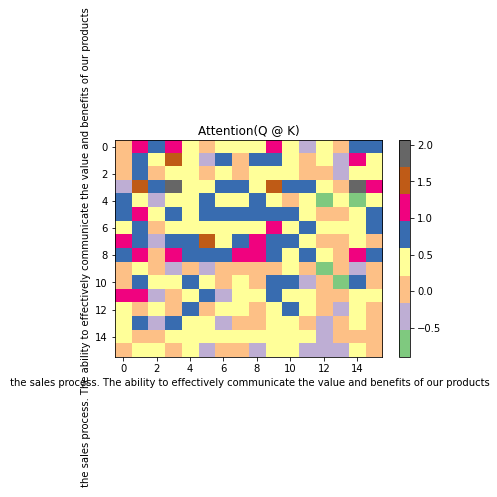

In [25]:
# Calculate the attention score
attention_score = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_model // num_heads) # [4, 4, 16, 16]

# Illustration only
plt.imshow(attention_score[1, 1].detach().cpu().numpy(), "Accent", aspect="auto")
plt.title("Attention(Q @ K)") #plot attention in the first head of the first batch
plt.xlabel(encoding.decode(x_batch[0].tolist()))
plt.ylabel(encoding.decode(x_batch[0].tolist()))
plt.colorbar()
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.062872,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
1,0.062696,0.062573,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
2,0.062628,0.062568,0.062531,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
3,0.062566,0.062542,0.062528,0.062560,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
4,0.062559,0.062568,0.062530,0.062501,0.062519,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
5,0.062524,0.062534,0.062523,0.062533,0.062517,0.062526,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
6,0.062534,0.062565,0.062518,0.062505,0.062516,0.062495,0.062508,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
7,0.062509,0.062539,0.062531,0.062501,0.062514,0.062507,0.062517,0.062505,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
8,0.062529,0.062505,0.062517,0.062511,0.062516,0.062503,0.062497,0.062512,0.062517,-inf,-inf,-inf,-inf,-inf,-inf,-inf
9,0.062521,0.062513,0.062508,0.062527,0.062508,0.062496,0.062498,0.062498,0.062501,0.062520,-inf,-inf,-inf,-inf,-inf,-inf


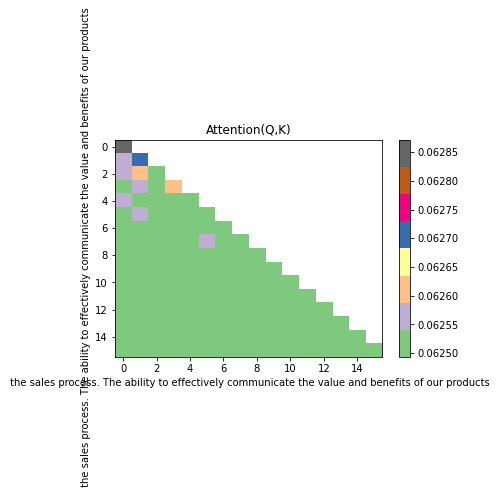

In [40]:
# Apply Mask to attention scores
attention_score = attention_score.masked_fill(torch.triu(torch.ones(attention_score.shape[-2:]).to(device), diagonal=1).bool(), float('-inf'))#[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]

# Illustration only
plt.imshow(attention_score[1, 1].detach().cpu().numpy(), "Accent", aspect="auto")
plt.title("Attention(Q,K)")
plt.xlabel(encoding.decode(x_batch[0].tolist()))
plt.ylabel(encoding.decode(x_batch[0].tolist()))
plt.colorbar()
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

In [35]:
attention_score[0][0]

tensor([[0.0629, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
         0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625],
        [0.0627, 0.0626, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
         0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625],
        [0.0626, 0.0626, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
         0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625],
        [0.0626, 0.0625, 0.0625, 0.0626, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
         0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625],
        [0.0626, 0.0626, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
         0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625],
        [0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
         0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625],
        [0.0625, 0.0626, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
         0.0625, 0.0625, 0.0625, 0.06

In [41]:
# Softmax the attention score
attention_score = torch.softmax(attention_score, dim=-1) #[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())
from bertviz import head_view, model_view

att_first_head = [attention_score[i].unsqueeze(0) for i in range(batch_size)]
print(att_first_head[0].shape)

token_list = [[encoding.decode_single_token_bytes(i).decode('utf-8')] for i in x_batch[0].tolist()]
head_view(att_first_head, token_list, prettify_tokens=False)

torch.Size([1, 4, 16, 16])


<IPython.core.display.Javascript object>

[b' the',
 b' sales',
 b' process',
 b'.',
 b' The',
 b' ability',
 b' to',
 b' effectively',
 b' communicate',
 b' the',
 b' value',
 b' and',
 b' benefits',
 b' of',
 b' our',
 b' products']

In [85]:
# Calculate the V attention output
print(attention_score.shape) #[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]
print(V.shape) #[4, 4, 16, 16] [batch_size, num_heads, context_length, head_size]
A = torch.matmul(attention_score, V) # [4, 4, 16, 16] [batch_size, num_heads, context_length, head_size]
print(A.shape)

torch.Size([4, 4, 16, 16])
torch.Size([4, 4, 16, 16])
torch.Size([4, 4, 16, 16])


In [86]:
# Concatenate the attention output
A = A.transpose(1, 2) # [4, 16, 4, 16] [batch_size, context_length, num_heads, head_size]
A = A.reshape(batch_size, -1, d_model) # [4, 16, 64] [batch_size, context_length, d_model]
A.shape

torch.Size([4, 16, 64])

In [88]:
# Define the output weight matrix  
Wo = nn.Linear(d_model, d_model).to(device)
output = Wo(A) # [4, 16, 64] [batch_size, context_length, d_model]
print(output.shape)
pd.DataFrame(output[0].detach().cpu().numpy())

torch.Size([4, 16, 64])


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.217016,-0.084742,0.135017,-0.244709,0.000267,0.052206,-0.403072,-0.177751,0.189971,-0.335659,...,-0.689762,0.036375,-0.546142,-0.325927,-0.652442,-0.099255,1.006100,-0.170647,-0.458756,0.685856
1,-0.014204,0.007856,0.449970,-0.183704,0.117348,0.424739,-0.040474,-0.437166,-0.303344,-0.191225,...,-0.643533,-0.138316,-0.245559,-0.264239,-0.227470,-0.099347,0.923428,-0.145727,-0.320921,0.385725
2,0.019643,0.179037,0.452983,-0.134549,0.013718,0.316029,-0.036011,-0.537750,-0.230358,-0.249379,...,-0.625180,-0.265652,-0.135304,-0.292224,-0.100959,-0.175635,0.792728,-0.207391,-0.153791,0.483166
3,-0.012626,0.183284,0.330691,-0.161986,-0.258927,0.325882,-0.082581,-0.377961,0.030390,-0.240397,...,-0.618272,-0.154178,-0.278331,-0.455783,-0.322355,-0.225979,0.666613,-0.318927,-0.201652,0.424324
4,-0.007003,0.024983,0.497118,-0.094114,-0.014453,0.439430,0.161494,-0.409057,-0.359311,-0.291362,...,-0.481018,-0.276340,-0.149641,-0.318481,-0.216158,-0.207018,0.590208,-0.093836,-0.100525,0.503712
5,0.049260,0.168196,0.472927,-0.016483,-0.044058,0.453200,0.112382,-0.525736,-0.452219,-0.168529,...,-0.314086,-0.188003,-0.100332,-0.136314,-0.285772,-0.231868,0.471303,-0.061962,0.014329,0.449963
6,0.029410,0.122121,0.445532,-0.106266,-0.389482,0.347624,-0.001219,-0.427150,-0.255703,-0.234435,...,-0.400509,0.001975,0.003193,-0.045210,-0.227008,-0.272350,0.344958,-0.147570,0.021608,0.310252
7,-0.062457,0.073995,0.562828,-0.083563,-0.313824,0.265149,0.069197,-0.289367,-0.296340,-0.297738,...,-0.513482,-0.162489,0.021681,-0.080604,-0.133677,-0.320884,0.322981,-0.264813,-0.053330,0.303045
8,-0.061925,-0.067144,0.552656,-0.182246,-0.380006,0.312812,0.039628,-0.203110,-0.319137,-0.246367,...,-0.465008,-0.057121,0.081486,-0.024926,-0.169069,-0.291227,0.360913,-0.249238,-0.010103,0.355879
9,-0.087743,-0.045892,0.434540,-0.210696,-0.304989,0.185267,0.098944,-0.147714,-0.173429,-0.245965,...,-0.488839,-0.094635,-0.006074,-0.043080,-0.206076,-0.316299,0.282998,-0.332709,-0.091007,0.333669


In [89]:
# Add residual connection
output = output + X

In [91]:
# Add Layer Normalization
layer_norm = nn.LayerNorm(d_model).to(device)
output_layernorm = layer_norm(output)

In [95]:
# Define Feed Forward Network
output = nn.Linear(d_model, d_model * 4).to(device)(output_layernorm)
output = nn.ReLU()(output)#GPT2 使用的是GELU
output = nn.Linear(d_model * 4, d_model).to(device)(output)
output = torch.dropout(output, p=dropout, train=True)

In [97]:
# Add residual connection & layerNorm (last time in a Transformer block)
output = output + output_layernorm
# Add Layer Normalization
layer_norm = nn.LayerNorm(d_model).to(device)
output = layer_norm(output)
print(output.shape)

torch.Size([4, 16, 64])


In [39]:
# Until here, we finished a Transformer block,
# We actually should pack the above Transformer block code into a call and 
# repeat the steps for num_layers times
# but this jupyter notebook is purely for illustration purpose, so we'll skip it:
# for _ in range(num_layers):
#   do loop for each transformer block

In [98]:
# Apply the final linear layer to get the logits
logits = nn.Linear(d_model, max_token_value+1).to(device)(output)
pd.DataFrame(logits[0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,...,100060,100061,100062,100063,100064,100065,100066,100067,100068,100069
0,0.699889,0.067918,-0.634786,-0.357409,-0.673917,-0.331706,0.696167,-0.091017,-0.722944,-0.360267,...,-0.782245,0.492716,-0.082211,-0.200308,0.340353,0.645626,0.159549,0.231335,-0.916609,0.566967
1,-0.043923,0.842669,-0.811324,-1.005323,0.690466,-0.961382,0.149049,-0.540090,-0.894385,-0.020943,...,-0.784396,0.358747,0.856468,-0.308715,-1.323636,-0.285316,-0.649845,1.002369,-1.414068,-0.538024
2,0.749186,-0.506650,-0.434588,-0.445868,0.759063,-0.496680,0.078841,-0.578193,-0.365256,-0.197891,...,-0.640830,0.209265,0.411209,-0.377557,0.483537,0.307880,-0.269583,0.703815,-0.896296,-0.914952
3,0.593846,-0.789389,0.918571,-0.637551,-0.249694,-1.681807,-0.831299,0.447676,-0.140623,0.155540,...,-0.135003,0.848987,0.153852,-0.199449,0.320762,1.550381,-0.672137,0.810999,0.237895,-0.336545
4,0.688340,0.203208,0.281177,-0.917327,0.012510,-0.554566,-0.621813,-0.846084,0.006784,-1.279581,...,-0.537232,0.201810,-0.291289,-0.155264,0.598089,0.278135,-0.034789,0.907383,-1.280987,-0.978625
5,1.209526,0.501008,0.034262,-0.239460,0.003043,-0.514993,0.126025,-0.765895,-0.563620,-1.311750,...,-0.736756,-0.175019,0.641794,-0.625867,-0.652182,0.192813,0.310235,0.928811,-0.077395,-0.680317
6,0.239491,0.046244,0.835589,0.166568,0.022816,0.046815,-0.788950,-0.003148,0.777936,-0.457717,...,-0.599893,0.199913,-1.238151,0.500178,0.599558,0.432910,0.220746,0.245033,0.398025,0.050877
7,0.721512,-0.497658,1.445991,0.674838,0.546490,0.121619,-0.199805,-0.566199,-0.362724,-0.704795,...,0.081015,-0.388296,-0.500407,-0.535317,-0.092881,0.495739,0.117319,-0.088050,-0.311514,0.214502
8,-0.000906,-0.665848,-0.235621,0.366105,0.218972,0.577392,1.128100,0.669513,-0.409396,0.482542,...,-0.020269,-1.307224,-0.898660,-0.041316,-0.628863,-0.210426,-0.635423,0.262099,-0.463538,-0.580624
9,0.598448,0.580680,0.765106,-1.578190,0.099569,-0.066504,-0.370099,0.546608,-0.289888,-0.373627,...,-0.487724,0.416365,0.066614,-0.992053,0.289519,0.075313,0.743664,-0.170509,-0.441340,-0.857386


In [101]:
# Get the probabilities 
# torch.softmax usually used during inference, during training we use torch.nn.CrossEntropyLoss
# but for illustration purpose, we'll use torch.softmax here
probabilities = torch.softmax(logits, dim=-1)
pd.DataFrame(probabilities[0].detach().cpu().numpy())
probabilities.shape

torch.Size([4, 16, 100070])

In [102]:
# Let's see the predicted token and it's original English word
predicted_index = torch.argmax(logits[0,0]).item()
encoding.decode([predicted_index])

' ratios'

In [32]:
# Let's see the original input sentence
encoding.decode(x_batch[0].tolist())

' the sales process. The ability to effectively communicate the value and benefits of our products'

In [ ]:
# Looks like the predicted token "Catholics" is not the correct prediction token to the original sentence, because we only did one training loop and barely trained nothing.
# But this is the basic idea of how the Transformer works.
# We'll continue to train the model in the next notebook and wrap the above code into a class.
# https://waylandzhang.github.io/en/let-s-code-llm.html